# BiLSTM architectures for Sequence Labeling

The objetive of this notebook is to build different BiLSTM prototype networks for sequence labeling, and apply a very simple attention mechanisms before the recurrent layer. The base model is inpired in [this work](https://www.kaggle.com/gagandeep16/ner-using-bidirectional-lstm), by GaganBhatia. Most of the explanations of the code is in the accompaning slides.

In [1]:
! mkdir data; wget -O data/data.sample.csv -nc https://cs.famaf.unc.edu.ar/~mteruel/datasets/tensorflowMeetup/ner.sample.csv

mkdir: cannot create directory ‘data’: File exists
wget: /home/milagro/miniconda2/envs/am_env/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /home/milagro/miniconda2/envs/am_env/lib/libssl.so.1.0.0: no version information available (required by wget)
wget: /home/milagro/miniconda2/envs/am_env/lib/libssl.so.1.0.0: no version information available (required by wget)
File `data/data.sample.csv' already there; not retrieving.


In [1]:
%matplotlib inline
import gzip
import keras
import numpy
import pandas
import pickle
import os
import seaborn

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn import metrics

Using TensorFlow backend.


In [2]:
dataset = pandas.read_csv("data/data.sample.csv", encoding = "ISO-8859-1", error_bad_lines=False,
                          usecols=['sentence_idx', 'word', 'pos', 'tag'])

Let's take a look at the dataset

In [3]:
dataset[:10]

,pos,sentence_idx,word,tag
0,NNS,1,Thousands,O
1,IN,1,of,O
2,NNS,1,demonstrators,O
3,VBP,1,have,O
4,VBN,1,marched,O
5,IN,1,through,O
6,NNP,1,London,B-geo
7,TO,1,to,O
8,VB,1,protest,O
9,DT,1,the,O


In [4]:
class SentenceFactory(object):
    
    def __init__(self, dataset, tag_preprocess=lambda x: x):
        self.dataset = dataset
        agg_func = lambda s: [
            (w, p, tag_preprocess(t)) 
            for w, p, t in zip(s["word"].values.tolist(), s['pos'].values.tolist(),
                               s["tag"].values.tolist())
        ]
        grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in grouped]

In [5]:
instances = SentenceFactory(dataset).sentences

instances[0:1]

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')]]

In [6]:
unique_words = dataset.word.unique()
unique_words.sort()
unique_words = numpy.append(unique_words, "ENDPAD")
print('Vocabulary size {}'.format(unique_words.shape[0]))

Vocabulary size 10923


In [7]:
unique_words

array(['!', '"', '$', ..., '\x85', '°C', 'ENDPAD'], dtype=object)

In [8]:
labels = dataset.tag.fillna('O').unique()
print(labels)
print('Unique labels {}'.format(labels.shape[0]))

['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']
Unique labels 17


## Processing the input sequences

We need to pad our sequences to the same number of words, so the network can build a tensor from our (variable lenght) sentences. There are workarounds for this step, but maybe for another tutorial. In this case, we choose to use the lenght of the longest sequence.

In [9]:
max_sentence_length = dataset.groupby('sentence_idx').word.count().max()
max_sentence_length

70

In [10]:
word2idx = {w: i for i, w in enumerate(unique_words)}
labels2idx = {t: i for i, t in enumerate(labels)}

In [11]:
x_matrix = [[word2idx[w[0]] for w in s] for s in instances]
x_matrix = pad_sequences(maxlen=max_sentence_length, sequences=x_matrix,
                         padding="post", value=unique_words.shape[0] - 1)

In [12]:
y = [[labels2idx[w[2]] for w in s] for s in instances]
y = pad_sequences(maxlen=max_sentence_length, sequences=y, padding="post", value=labels2idx["O"])
y = [to_categorical(i, num_classes=labels.shape[0]) for i in y]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_matrix, y, test_size=0.2)

In [14]:
y_train[:2]

[array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]])]

--- 

# Building the model

We build a model with an object oriented interface so we can add and remove layers in sub-classes. This is the vanilla model, which is only using the middle BiLSTM layer.

In [15]:
from keras import Model
from keras.layers import (Bidirectional, concatenate, Conv1D, Dense,
                          Dropout, Embedding, GlobalMaxPooling1D, Input,
                          LSTM, TimeDistributed)

In [16]:
class BaseBiLSTM(object):
    def __init__(self, vocabulary_size, max_sentence_length, labels,
                 embedding_size=50):
        self.model = None
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.max_sentence_length = max_sentence_length
        self.labels = labels
        self.n_labels = labels.shape[0]
    
    def add_input_layer(self):
        return Input(shape=(None, ))
        
    def add_embedding_layer(self, layers):
        layers = Embedding(
            input_dim=self.vocabulary_size,
            output_dim=self.embedding_size,
            input_length=self.max_sentence_length)(layers)
        return Dropout(0.1)(layers)
    
    def add_recurrent_layer(self, layers):
        layers = Bidirectional(
            LSTM(units=100, return_sequences=True,
                 recurrent_dropout=0.1))(layers)
        return layers
    
    def add_output_layer(self, layers):
        layers = TimeDistributed(
            Dense(self.n_labels, activation='softmax'), name='dense_layer')(layers)
        return layers, 'categorical_crossentropy'
    
    def build(self):
        inputs = self.add_input_layer()
        layers = self.add_embedding_layer(inputs)
        layers = self.add_recurrent_layer(layers)
        outputs, loss_function = self.add_output_layer(layers)        
        
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer='adam', loss=loss_function,
                           metrics=['accuracy'])
    
    def fit(self, X_train, y_train, epochs, batch_size=32, validation_split=0.2):
        if self.model is None:
            self.build()
        return self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                              validation_split=validation_split, verbose=1)
    
    def predict(self, X_test):
        return numpy.argmax(self.model.predict(X_test), axis=-1)
    
    def evaluate(self, X_test, y_test, cm=False):
        predictions = numpy.argmax(self.model.predict(X_test), axis=-1).flatten()
        true_labels = numpy.argmax(y_test, axis=-1).flatten()
        print(metrics.classification_report(true_labels, predictions,
                                            target_names=self.labels))
        if cm:
            seaborn.heatmap(
                metrics.confusion_matrix(true_labels, predictions, labels=range(len(self.labels))),
                xticklabels=self.labels, yticklabels=self.labels)

In [17]:
model = BaseBiLSTM(
    vocabulary_size=len(word2idx) + 1, max_sentence_length=max_sentence_length,
    labels=labels, embedding_size=50)
model.build()
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 50)            546200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 200)           120800    
_________________________________________________________________
dense_layer (TimeDistributed (None, 70, 17)            3417      
Total params: 670,417
Trainable params: 670,417
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train=X_train[:100], y_train=numpy.array(y_train)[:100], epochs=1)

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 2s 29ms/step - loss: 2.8218 - acc: 0.3314 - val_loss: 2.7312 - val_acc: 0.9486


---
# Adding pre-trained word embeddings

To preload the weights of a previous embedding, we only need to add an embedding layer with a pre-set weights. However, the indices of the tokens in our data won't be the same as the ones in the pretrained embeddings. As a result, we need a pretraining step where we map our training vocabulary.

This process is pretty straight forward and there are several tutorials online that delve deeper into this.

In [19]:
def build_embedding_matrix(vocabulary, embeddings_filepath):
    # TODO We are using the Konminos embeddings in part because they are easy to load
    # but you should overwrite this part to fit every particular word embedding to load.
    # Warning, this may consume your RAM, depedending on the type of embedding
    # you are loading!
    if vocabulary is None:
        raise ValueError('vocabulary cannot be empty')
    original_embeddings = gzip.open(embeddings_filepath, 'rt')
    embedding_size = None
    embeddings = None
    not_found_words = 0
    for line in original_embeddings:
        split = line.rstrip().split(" ")
        word = split[0]
        if embedding_size is None:  # Only runs first time
            embedding_size = len(split) - 1
            # We add one more place for the padding token
            embeddings = numpy.zeros((len(vocabulary) + 1, embedding_size))

        # Assure that all lines in the embeddings file are of the same length
        if (len(split) - 1) != embedding_size:
            print('ERROR: A line in the embeddings file had more or less '
                  'dimensions than expected. Skip token.')
            continue

        if word in vocabulary:
            vector = numpy.array([float(num) for num in split[1:]])
            embeddings[vocabulary[word]] = vector  # Save the embedding in the
                                                   # correct row
        # If the word is not in vocabulary, we ignore the embedding.                
    del original_embeddings
    # Calculate which words are still missing
    empty_words = numpy.where(embeddings.any(axis=1))[0]
    print('{} words will be set with a random embedding')
    # Replace missing words with a random vector (so far they are all zeros)
    embeddings[empty_words] = numpy.random.uniform(-0.25, 0.25, embedding_size)

    # Adding padding token at the end
    embeddings[-1,:] = numpy.zeros(embedding_size)
    return embeddings

We save the embeddings to avoid calculating them again. After the first time you run this cell, comment this two lines and read the embeddings from disk directly. It is very important to keep a copy of your original word2idx, in case you need to preprocess new data. In this case, we are using always the same dataset and ordering the tokens, so we shouldn't have inconsistencies preprocessing the text more than once.

In [20]:
! mkdir models

mkdir: cannot create directory ‘models’: File exists


In [21]:
embeddings_matrix = build_embedding_matrix(
    vocabulary=word2idx,
    embeddings_filepath='../../../am/data/embeddings/komninos_english_embeddings.gz')

with open(os.path.join('models', 'komninos_word_embeddings.pickle'), 'wb') as file_:
      pickle.dump([embeddings_matrix, word2idx], file_)

{} words will be set with a random embedding


In [22]:
with open(os.path.join('models', 'komninos_word_embeddings.pickle'), 'rb') as file_:
      embeddings_matrix, _ = pickle.load(file_)

In [23]:
class WEmbBiLSTM(BaseBiLSTM):
    
    def add_word_embeddings(self, embeddings):
        """Saves into the model a matrix with the original weights for 
        the word embeddings.
        
        MUST BE CALLED BEFORE build, otherwise it has no effect.

        Args:
            embeddings: (numpy.ndarray) a 2-dimensional matrix with shape
                (vocabulary_size, embedding_size).
        """
        self.embeddings = embeddings
        self.embedding_size = embeddings.shape[1]  # Overwrite this value
        self.vocabulary_size = embeddings.shape[0]  # Overwrite this value

    def add_embedding_layer(self, layers):
        if self.embeddings is not None:  # Add the pretrained embeddings
            layers = Embedding(
                input_dim=self.vocabulary_size, output_dim=self.embedding_size,
                weights=[self.embeddings],
                trainable=False, input_length=self.max_sentence_length)(layers)
        else:  # We use brand new embeddings
            layers = Embedding(
                input_dim=self.vocabulary_size, output_dim=self.embedding_size,
                input_length=self.max_sentence_length)(layers)
        return Dropout(0.1)(layers)

In [24]:
model = WEmbBiLSTM(
    vocabulary_size=len(word2idx) + 1, max_sentence_length=max_sentence_length,
    labels=labels, embedding_size=300)
model.add_word_embeddings(embeddings_matrix)
model.build()
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 300)           3277200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 300)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 200)           320800    
_________________________________________________________________
dense_layer (TimeDistributed (None, 70, 17)            3417      
Total params: 3,601,417
Trainable params: 324,217
Non-trainable params: 3,277,200
_________________________________________________________________


In [25]:
model.embeddings

array([[ 0.23887191, -0.15608303,  0.02537438, ...,  0.06760797,
         0.04049218, -0.22385186],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.23887191, -0.15608303,  0.02537438, ...,  0.06760797,
         0.04049218, -0.22385186],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [26]:
model.fit(X_train=X_train[:100], y_train=numpy.array(y_train)[:100], epochs=1)

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 2s 27ms/step - loss: 2.6705 - acc: 0.5798 - val_loss: 2.3072 - val_acc: 0.9486


---
# Adding character embeddings

Before adding the character embeddings, we need to assign an index to each char.

Now, the char input will be a 4-dimensional tensor, because each word is a list of characters.

In [27]:
max_word_len = max([len(word) for word in unique_words])
max_word_len

26

In [28]:
print('And the words that complicates everything are: {}'.format(
    unique_words[numpy.argsort([len(word) for word in unique_words])[-10:]]))

And the words that complicates everything are: ['Pakistani-controlled' 'bigger-than-expected' 'pro-U.S.-immigration'
 'Chancellor-designate' 'government-controlled' "Baku-T'bilisi-Erzerum"
 'multi-million-selling' 'counter-revolutionary' 'internationally-backed'
 'internationally-recognized']


In [29]:
unique_chars, counts = numpy.unique([c for c in ''.join(unique_words)], return_counts=True)
char_limit = 60
char2idx = {c: idx + 1 for idx, c in enumerate(unique_chars[numpy.argsort(counts)[-1*char_limit:]])}
char2idx['UNK'] = len(char2idx) + 1
char2idx['PAD'] = 0  # This is not needed, it's only for clarification
'{} unique characters used'.format(len(char2idx))

'62 unique characters used'

In [30]:
def extract_chars(train_matrix):
    char_matrix = numpy.zeros(train_matrix.shape + (max_word_len,) )
    unknown_char_idx = len(char2idx) - 1
    for example_idx, sentence in enumerate(train_matrix):
        for token_position, word_idx in enumerate(sentence):
            if word_idx == len(unique_words):  # Padding token
                continue
            chars = [char2idx.get(c, unknown_char_idx) for c in unique_words[word_idx]]
            char_matrix[example_idx, token_position, :len(chars)] = chars
    return char_matrix

In [31]:
extract_chars(X_train[:5]).shape

(5, 70, 26)

Now we can finally build our model. We need to add one more input and the new character embeddings layer. We build a single model for both types of embeddings to ilustrate the fact that they share a lot of code, but ideally this should be implemented in different models.

In [32]:
class CEmbWEmbBiLSTM(WEmbBiLSTM):
    def __init__(self, vocabulary_size, max_sentence_length, labels,
                 embedding_size=50, max_char_index=50, char_embedding_type='cnn',
                 max_word_length=20):
        super(CEmbWEmbBiLSTM, self).__init__(vocabulary_size, max_sentence_length,
                                             labels, embedding_size)
        self.max_char_index = max_char_index
        self.char_embedding_type = char_embedding_type
        self.max_word_length = max_word_length
    
    def add_input_layer(self):
        word_input = Input(shape=(self.max_sentence_length,), name='word_input')
        char_input = Input(shape=(self.max_sentence_length, self.max_word_length), name='char_input')
        return word_input, char_input
    
    def add_char_embedding_layer(self, char_input):
        """Add a convolution for the characters"""
        limit = numpy.sqrt(3.0/self.max_char_index)
        char_embedding_size = 15  # TODO define this as a parameter
        # We initialize the char embeddings randomly, including the
        # UNK char in position 0.
        self.char_embeddings = numpy.random.uniform(
            -limit, limit, (self.max_char_index + 1, char_embedding_size))

        # We need the TimeDistributed layer to apply the embedding to every word
        chars_layer = TimeDistributed(Embedding(
            input_dim=self.char_embeddings.shape[0],
            output_dim=self.char_embeddings.shape[1],
            weights=[self.char_embeddings], trainable=True,
            mask_zero=True), name='char_embedding')(char_input)

        if self.char_embedding_type.lower() == 'lstm':
            # Use LSTM for char embeddings from Lample et al., 2016
            char_lstm_size = 10  # TODO define this as a parameter
            chars_layer = TimeDistributed(Bidirectional(
                LSTM(char_lstm_size, return_sequences=False)),
                name="char_lstm")(chars_layer)
        elif self.char_embedding_type.lower() == 'cnn':
            # Use CNNs for character embeddings from Ma and Hovy, 2016
            char_filter_size = 5  # TODO define this as a parameter
            char_filter_length = 5  # TODO define this as a parameter
            chars_layer = TimeDistributed(
                Conv1D(char_filter_size, char_filter_length, padding='same'),
                name="char_cnn")(chars_layer)
            chars_layer = TimeDistributed(GlobalMaxPooling1D(),
                                          name="char_pooling")(chars_layer)
        return chars_layer
    
    def add_embedding_layer(self, layers):
        word_input, char_input = layers
        # Add word embeddings with the previous method
        word_layers = super(CEmbWEmbBiLSTM, self).add_embedding_layer(word_input)
        
        # Add char embeddings
        char_layer = self.add_char_embedding_layer(char_input)
        return concatenate([word_layers, char_layer])

In [33]:
model = CEmbWEmbBiLSTM(
    vocabulary_size=len(word2idx) + 1, max_sentence_length=max_sentence_length,
    labels=labels, embedding_size=300,
    max_char_index=max(char2idx.values()),  # The max possible id for a character
    char_embedding_type='cnn', max_word_length=max_word_len)
model.add_word_embeddings(embeddings_matrix)
model.build()
model.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 70, 26)       0                                            
__________________________________________________________________________________________________
word_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 70, 26, 15)   930         char_input[0][0]                 
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      3277200     word_input[0][0]                 
__________________________________________________________________________________________________
char_cnn (

In [34]:
model.fit(X_train=[X_train[:100], extract_chars(X_train[:100])],
          y_train=numpy.array(y_train)[:100], epochs=1)

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 3s 41ms/step - loss: 2.7042 - acc: 0.4779 - val_loss: 2.3154 - val_acc: 0.9486


Let's try the other model now!

In [35]:
model = CEmbWEmbBiLSTM(
    vocabulary_size=len(word2idx) + 1, max_sentence_length=max_sentence_length,
    labels=labels, embedding_size=300,
    max_char_index=max(char2idx.values()),  # The max possible id for a character
    char_embedding_type='lstm', max_word_length=max_word_len)
model.add_word_embeddings(embeddings_matrix)

In [36]:
model.fit(X_train=[X_train[:100], extract_chars(X_train[:100])],
          y_train=numpy.array(y_train)[:100], epochs=1)

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 5s 57ms/step - loss: 2.7267 - acc: 0.5718 - val_loss: 2.3560 - val_acc: 0.9486


In [37]:
model.model.save('models/CEmbLSTMWEmbBiLSTM.keras')

In [38]:
model.build()
model.model.load_weights('models/CEmbLSTMWEmbBiLSTM.keras')

/home/milagro/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          O       0.95      1.00      0.98      6663
      B-geo       0.00      0.00      0.00        75
      B-gpe       0.00      0.00      0.00        37
      B-per       0.00      0.00      0.00        36
      I-geo       0.00      0.00      0.00        14
      B-org       0.00      0.00      0.00        47
      I-org       0.00      0.00      0.00        35
      B-tim       0.00      0.00      0.00        41
      B-art       0.00      0.00      0.00         2
      I-art       0.00      0.00      0.00        35
      I-per       0.00      0.00      0.00        14
      I-gpe       0.00      0.00      0.00         1

avg / total       0.91      0.95      0.93      7000



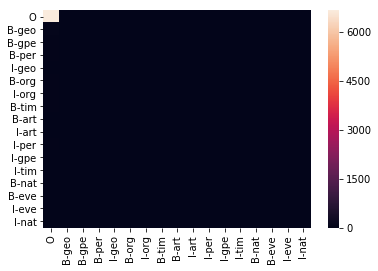

In [39]:
model.evaluate([X_train[:100], extract_chars(X_train[:100])], numpy.array(y_train)[:100], cm=True)

---
# Adding the CRF layer

Last, we are going to add the CRF layer on top of everything else.

We are using the code originally in [UKPLab EMNLP repository](github.com/uKPLab/emnlp2017-bilstm-cnn-crf) that I'm only copying into this repository to avoid compatibility problems.

In [40]:
from ChainCRF import ChainCRF

In [41]:
class CEmbWEmbBiLSTMCRF(CEmbWEmbBiLSTM):
    def __init__(self, vocabulary_size, max_sentence_length, labels,
                 embedding_size=50, max_char_index=50, char_embedding_type='cnn',
                 max_word_length=20, classifier='softmax'):
        super(CEmbWEmbBiLSTMCRF, self).__init__(
            vocabulary_size, max_sentence_length, labels,
            embedding_size, max_char_index, char_embedding_type, max_word_len)
        self.classifier = classifier

    def add_output_layer(self, layers):
        print(layers)
        if self.classifier.lower() == 'softmax':
            output = TimeDistributed(
                Dense(len(self.labels), activation='softmax'),
                name=modelName+'_softmax')(layers)
            loss_function = 'sparse_categorical_crossentropy'
        elif self.classifier.lower() == 'crf':
            output = TimeDistributed(Dense(len(self.labels), activation=None),
                                     name='hidden_lin_layer')(layers)
            crf = ChainCRF(name='crf_layer')
            output = crf(output)
            loss_function = crf.loss
        else:
            raise ValueError('The classifier must be softmax of CRF')
        return output, loss_function

In [42]:
model = CEmbWEmbBiLSTMCRF(
    vocabulary_size=len(word2idx) + 1, max_sentence_length=max_sentence_length,
    labels=labels, embedding_size=300,
    max_char_index=max(char2idx.values()),  # The max possible id for a character
    char_embedding_type='cnn', max_word_length=max_word_len,
    classifier='crf')
model.add_word_embeddings(embeddings_matrix)
model.build()
model.model.summary()

Tensor("bidirectional_8/concat:0", shape=(?, ?, 200), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 70, 26)       0                                            
__________________________________________________________________________________________________
word_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 70, 26, 15)   930         char_input[0][0]                 
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 70, 300)      3277200     word_input[0][0]                 
________________________________________

In [43]:
model.fit(X_train=[X_train[:100], extract_chars(X_train[:100])],
          y_train=numpy.array(y_train)[:100], epochs=1)

Train on 80 samples, validate on 20 samples
Epoch 1/1
80/80 [==============================] - 4s 52ms/step - loss: 192.6944 - acc: 0.5980 - val_loss: 185.4018 - val_acc: 0.3493
